# CAB420, Classification, Example 3: Classification Metrics 
Dr Simon Denman (s.denman@qut.edu.au)

## Overview
To this point, we've simply used raw accuacy as our performance measure. This can be expressed as:

$A = \frac{TP + TN}{N}$

where $A$ is the overall accuracy, $TP$ is the number of true positives (i.e. points that are true that we classify as true), $TN$ is the number of true negatives (points that we correctly label as false) and $N$ is the total number of samples. This is a very intuitive measure, but it also lacks nuance and doesn't tell us much about the type of errors our model makes. 

In a binary classification case, we have two possible types of errors:
* False Positive: classifying something that belongs to class 0 as class 1 (also referred to as a false detection)
* False Negative: classifying something that belongs to class 1 as class 0 (also referred to as a missed detection)
Extending this to a multi-class case, we also have confusion between classes.

All of these errors are well captured by a confusion matrix (which is why confusion matrices are so good), but when evaluating lots of models we'd also like to be able to obtain one or more numbers to capture performance, as when simply looking at confusion matrices en-masse, it may be easy to miss key details.

This example will re-use the data from our second classification example (mulit-class beer classification) and explore some alternate performance metrics that better capture performance.

## Too Long; Didn't Read
* Accuracy, while simple, doesn't tell us a lot about the type of errors our system makes. This can also overestimate performance when dealing with class imbalance
* Precision, Recall and F1 score provide more information about how our system is working, and can be derived from the confusion matrix. These metrics can be applied to binary and multi-class situations, and in a multi-class situation can be used to investigate the performance of individual classes and issues of class balance.
* ROC and DET curves can also be used to visualise performance as a detection/classification threshold changes. These can be very powerful for binary classifiers, but are harder to apply to a multi-class situation. These curves also require that the model output is probabilistic, i.e. we have a score that indicates how likely it is that a sample belongs to a class.

In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC, NuSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from scipy.stats import norm
from sklearn import tree

## The Data

We're using the same data and pre-procesing as Classification, Example 2. Refer to that example for further details.

In [2]:
craft_beer = pandas.read_csv('../data/craft-cans/beers.csv')
# remove beers with no style or name
craft_beer = craft_beer[~craft_beer['style'].isna()]
craft_beer = craft_beer[~craft_beer['name'].isna()]
# make style a categorical
craft_beer['style'] = pandas.Categorical(craft_beer['style'])
# obtain a histogram
counts = craft_beer['style'].value_counts()

# remove some beers that are rare
threshold = 50
to_remove = counts[counts <= threshold].index
# remove the beers, then remove the now unloved categories
craft_beer = craft_beer[~craft_beer['style'].isin(to_remove)]
craft_beer['style'] = craft_beer['style'].cat.remove_unused_categories()
craft_beer.reset_index(inplace=True)
# recompute histogram
counts = craft_beer['style'].value_counts()

# store as list of names
names = []
for n in craft_beer['name']:
    # strip out punctuation
    names.append(n.translate(str.maketrans('', '', string.punctuation)))
    
# store as list of lists of words
names_tokens = []
for n in names:
    # break into tokens
    tokens = re.sub(r"[^a-z0-9]+", " ", n.lower()).split()
    names_tokens.append(tokens)

# train the model
embedding_size = 50
# note that we're going to include every word by setting min_count to 1, this means that even if the word only 
# occurs once, it will be in our model. This is perhaps not the best approach, but we have too small of a corpus
# to go ruling rare words out (they're all rare for us)
word_model = Word2Vec(sentences=names_tokens, vector_size=embedding_size, window=3, min_count=1, workers=4, sg=0)

max_words = 6
X = []
Y = []
for i,n in enumerate(names_tokens):    
    v = numpy.zeros(embedding_size*max_words)
    if (len(n) <= 6):
        for j,w in enumerate(n):
            v[j*embedding_size:(j+1)*embedding_size] = word_model.wv[w]
        X.append(v)
        Y.append(craft_beer['style'][i])        
        
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

To help explore the metrics, let's also grab a binary version of the data. To do this, we need to pick one beer to the be the "true" class, and all others will be false. As anyone who's bought craft beer recently, or simply looked in a bottle shop should be aware, the only "true" craft beer is the IPA - as such we'll setup a binary version of the data where the task will be to classify if the name of a beer is an IPA or not.

In [3]:
Y_train_binary = [i == 'American IPA' for i in Y_train]
Y_test_binary = [i == 'American IPA' for i in Y_test]

## Binary Classification

We'll start with a binary classification task. We'll use random forests throughout this example as they're fairly quick to train. Note that we're not critically concerned with accuracy here (though random forests are still good for that).

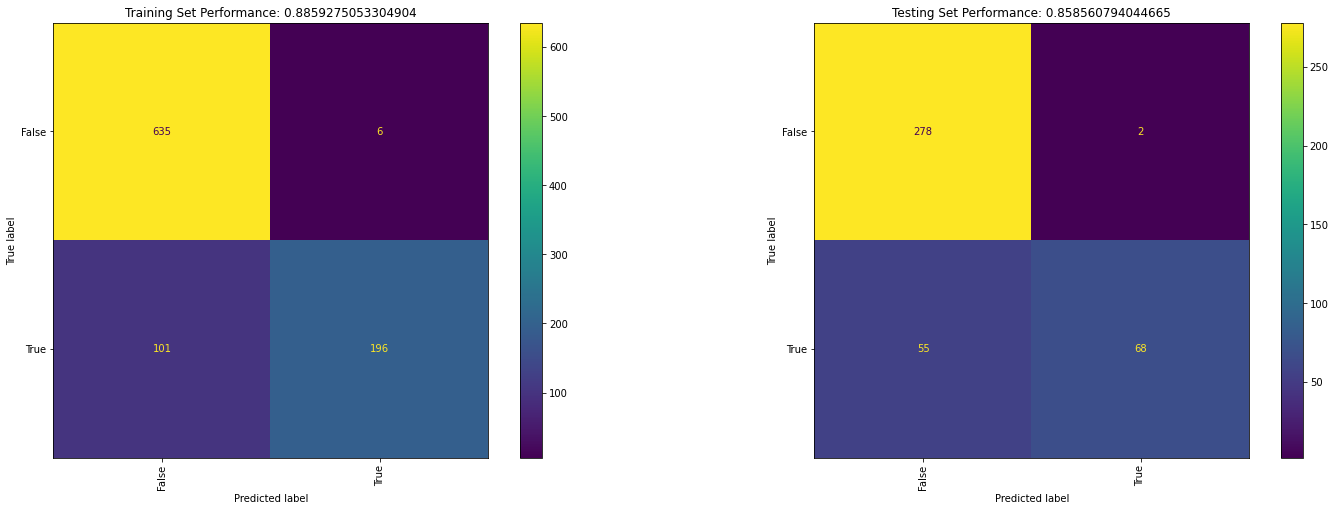

In [4]:
# function to do our eval for us, this is quite simple and will
# - create a figure
# - draw a confusion matrix for the trainign data in a sub-fig on the left
# - draw a confusion matrix for the testing data in a sub-fig on the right
# - compute the overall classification accuracy on the testing data
# this has simply been created as we're going to do this for each test that we run
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize=None, xticks_rotation='vertical', ax=ax)
    pred = model.predict(X_train)
    conf.ax_.set_title('Training Set Performance: ' + str(sum(pred == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize=None, xticks_rotation='vertical', ax=ax)
    pred = model.predict(X_test)
    conf.ax_.set_title('Testing Set Performance: ' + str(sum(pred == Y_test)/len(Y_test)));
    
rf = RandomForestClassifier(n_estimators=250, max_depth=4, random_state=0).fit(X_train, Y_train_binary)
eval_model(rf, X_train, Y_train_binary, X_test, Y_test_binary)

From the above we can see:
* Our model is, on the whole, quite accuracte (~85%)
* We're not great at classifying beers as IPAs, missing about half of them (is this a reflection of what passes for an IPA now and the diversification of the style? Perhaps I'm reading too much into this)

Raw accuracy doesn't capture this performance trait, so let's find something that does. In particular, we're going to look at precision, recall and the F1 score. First some definitions:
* True Positives (TP): These are samples/points that we correctly classify as True. This is the bottom right corner on the confusion matrix
* True Negatives (TN): These are samples/points that we correctly classify as False. This is the top left corner on the confusion matrix
* False Positives (FP): These are samples/points that we incorrectly classify as True, i.e. they are really False, but our model predicts them to the True. This is the top right corner on the confusion matrix.
* False Negatives (FN): These are samples/points that we incorrectly classify as False, i.e. they are really true, but we classify them as false. They are captured by the bottom left corner of the confusion matrix.

Given the above definitions, we have:

$P=\frac{TP}{TP+FP}$

where $P$ is the precision. We can view this as the total number of true positives, divided by the total number of detected positives, i.e. how often are things that we detect as being "true" actually "true".

$R=\frac{TP}{TP+FN}$

where $R$ is the recal. We can view this as the total number of true positives, divided by the total number of actual positives in the data, i.e. how many of the things that we are interested in did we actually detect.

$F1=\frac{2 \times P \times R}{P + R}$

The $F1$ score combines precision and recall, to obtain an overall measure of performance.

The accuracy metric we've been using could be defined in the same way as

$A = \frac{TP + TN}{TP + TN + FP + FN}$

This is simply considering how often the model is right (TP and TN) out of how many total samples are tested.

Let's now compute these and see what we get.

In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

print(precision_score(Y_test_binary, rf.predict(X_test)))
print(recall_score(Y_test_binary, rf.predict(X_test)))
print(f1_score(Y_test_binary, rf.predict(X_test)))

0.9714285714285714
0.5528455284552846
0.7046632124352332


Our precision is very high - this makes sense, almost everything that we classify as an IPA is in fact an IPA (we have very few false positives, see the top right corner of the confusion matrix).

Our recall is fairly ordinary. Again, looking at our confusion matrix we have a lot of false negatives (bottom left corner), i.e. a lot of beers that are actually IPAs we classify as something else. This drags this score down.

The F1 score (the harmonic mean of precision and recall) lies somewhere in the middle, but a long way below our accuracy score from above.

### ROC Curves, DET Plots and Other Animals

There are a number of other methods we can use depending on the classifier we have. If we have a model that outputs a likelihood, we can plot reciever operating characteristic (ROC) and detection error trade-off (DET) plots.

With a random forest, we do have this. Rather than get a hard decision, we can get a probability based on the number of trees that make each possibe decision in the forest.

In [6]:
print(rf.predict_proba(X_test))

[[0.93250748 0.06749252]
 [0.80424999 0.19575001]
 [0.82075072 0.17924928]
 [0.84586692 0.15413308]
 [0.77350193 0.22649807]
 [0.84976221 0.15023779]
 [0.8847537  0.1152463 ]
 [0.93649752 0.06350248]
 [0.8229509  0.1770491 ]
 [0.77955442 0.22044558]
 [0.09972466 0.90027534]
 [0.82383069 0.17616931]
 [0.81602162 0.18397838]
 [0.76412936 0.23587064]
 [0.02135943 0.97864057]
 [0.88648663 0.11351337]
 [0.10994502 0.89005498]
 [0.8230395  0.1769605 ]
 [0.79091368 0.20908632]
 [0.48974251 0.51025749]
 [0.87996855 0.12003145]
 [0.89778564 0.10221436]
 [0.83808577 0.16191423]
 [0.8633036  0.1366964 ]
 [0.90669314 0.09330686]
 [0.82314451 0.17685549]
 [0.86099372 0.13900628]
 [0.69692842 0.30307158]
 [0.8152076  0.1847924 ]
 [0.73895612 0.26104388]
 [0.88322548 0.11677452]
 [0.8227214  0.1772786 ]
 [0.80780597 0.19219403]
 [0.76182021 0.23817979]
 [0.80015588 0.19984412]
 [0.80482225 0.19517775]
 [0.84850113 0.15149887]
 [0.81715863 0.18284137]
 [0.93478239 0.06521761]
 [0.16146763 0.83853237]


From these scores, what we would normally do is apply a threshold, such that if for example the score for the positive class is greater than 0.5, we'd classify the sample as true. However, there is no need to use a threshold of 0.5 - we could use any value, and different values will give us different error rates. If for example, we set a threshold of 0.8, we will only classify a sample as being an IPA when the classification score indicates that the model is more certain.

ROC and DET curves plot performance as this threshold changes.

Text(0.5, 1.0, 'DET Curve')

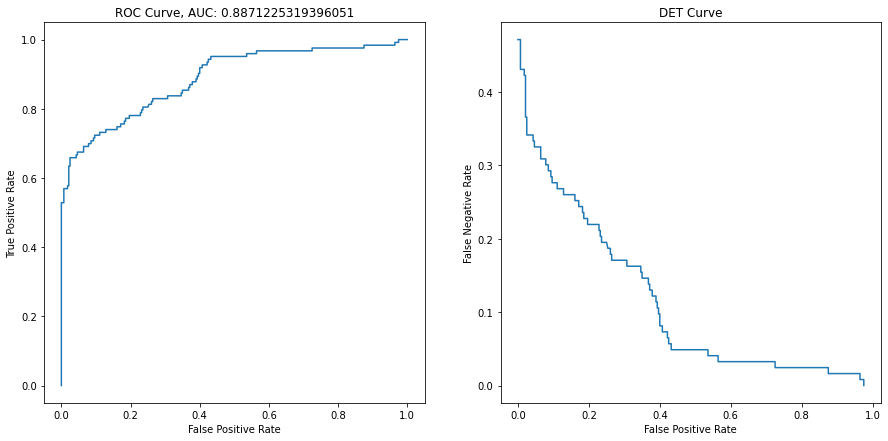

In [7]:
from sklearn.metrics import roc_curve, det_curve, roc_auc_score, auc

scores = rf.predict_proba(X_test)

fig = plt.figure(figsize=[15, 7])
fpr, tpr, thresholds = roc_curve(Y_test_binary, scores[:, 1])
auc_score = roc_auc_score(Y_test_binary, scores[:, 1])
ax = fig.add_subplot(1, 2, 1)
ax.plot(fpr, tpr)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve, AUC: ' + str(auc_score))

fpr, fnr, thresholds = det_curve(Y_test_binary, scores[:, 1])
ax = fig.add_subplot(1, 2, 2)
ax.plot(fpr, fnr)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('False Negative Rate')
ax.set_title('DET Curve')

Each point on these curves is showing the performance at a particular threshold - and these plots can be used to help select a threshold such that a desired operating characteristic is achieved. Each of these curves are showing very similar things, but in different ways. 

Considering the ROC curve (left) first, we have:
* True positive rate on the y axis. We want this to be as high as possible
* False positive rate on the x axis. We want this to be as low as possible

The ideal shape of the ROC curve is a vertical line straight up the y-axis at a false positive rate of 0, i.e. we can detect all instances of the target with no errors. In practice, this rarely happens (if it does, your problem is probably trivial), but in general we wish see the curve getting nice and close to the top left corner. You will often see the ROC chacterised by the area under the curve. Ideal performance leads to an AUC of 1.0.

The DET curve is showing a plotting the two errors against one another, such that we have:
* False negative rate on the y axis. We want this to be as small as possible
* False positive rate on the x axis. We want this to be as low as possible. This is the same as the ROC curve

For the DET curve, having the curve closer to the bottom left corner indicates better performance. One metric you may often see with a DET curve is the Equal Error Rate (EER), this is the point at which the two errors are equal.

We can create a poorly performing random forest (by greatly reducing the forest depth) to illustrate this.

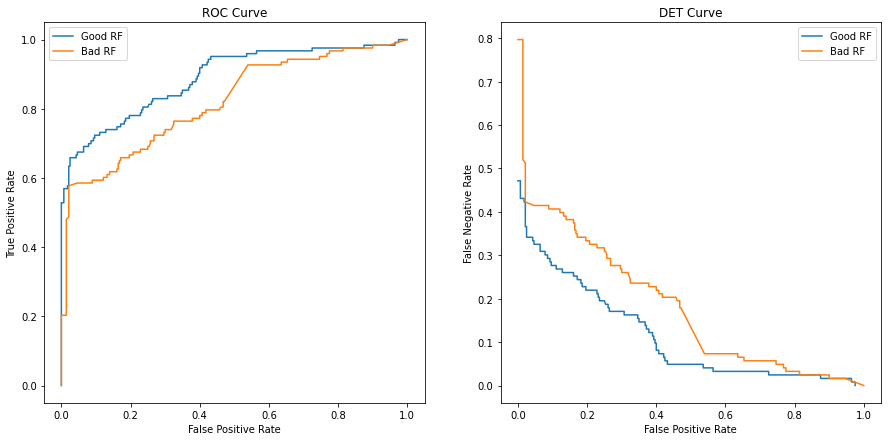

In [8]:
poor_rf = RandomForestClassifier(n_estimators=250, max_depth=1, random_state=0).fit(X_train, Y_train_binary)
poor_rf_scores = poor_rf.predict_proba(X_test)

fig = plt.figure(figsize=[15, 7])
ax = fig.add_subplot(1, 2, 1)
fpr, tpr, thresholds = roc_curve(Y_test_binary, scores[:, 1])
ax.plot(fpr, tpr)
fpr, tpr, thresholds = roc_curve(Y_test_binary, poor_rf_scores[:, 1])
ax.plot(fpr, tpr)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.legend(['Good RF', 'Bad RF'])

ax = fig.add_subplot(1, 2, 2)
fpr, fnr, thresholds = det_curve(Y_test_binary, scores[:, 1])
ax.plot(fpr, fnr)
fpr, fnr, thresholds = det_curve(Y_test_binary, poor_rf_scores[:, 1])
ax.plot(fpr, fnr)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('False Negative Rate')
ax.set_title('DET Curve')
ax.legend(['Good RF', 'Bad RF'])

We see our poor forest is further from the top left corner for the ROC curve, and further from the bottom left corner for the DET curve.

If we consider the ROC curve, note the point at which a true positive rate of 0.8 is achieved. For the "good RF", this is at a false positive rate of ~0.25-0.3. For the "bad RF", the false positive rate is ~0.4-0.45; i.e. for the "bad RF" to get the same false positive rate, we expect to generate a lot more errors. We can see the same trend on the DET curve, though this is showing the trade off between the two errors.

One key thing to note with both these plots is that there is a trade off between performance, though this is visualised in different ways. For the ROC curve, as we increase our true positive rate (which is the same as reducing our false negative rate), we observe an increase in the false positive rate. This trade-off is even more obvious in the DET (detection error trade-off) curve which directly plots the two errors against one another.

In pratice when considering classifier performance, you will most commonly see ROC curves, with DET curves largely restricted to the biometrics domain.

## Multi-Class Classification

Let's apply this to our multi-class classification now.

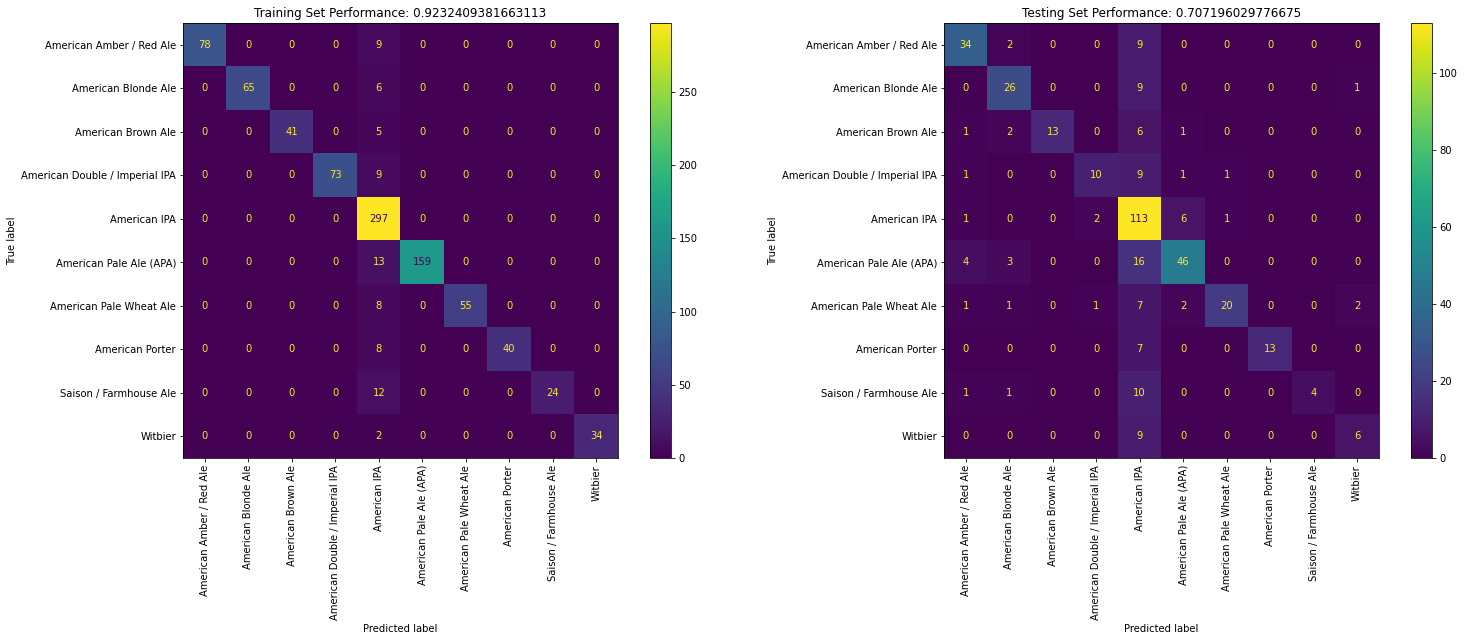

In [9]:
rf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=0).fit(X_train, Y_train)
eval_model(rf, X_train, Y_train, X_test, Y_test)

We'll compute our precision and recall per class, and see what that tells us. To do this we tell the functions that we use to compute our scores that the method to average results of multiple classes is None, i.e. just return the result per class.

In [10]:
print(precision_score(Y_test, rf.predict(X_test), average=None))
print(recall_score(Y_test, rf.predict(X_test), average=None))
print(f1_score(Y_test, rf.predict(X_test), average=None))

[0.79069767 0.74285714 1.         0.76923077 0.57948718 0.82142857
 0.90909091 1.         1.         0.66666667]
[0.75555556 0.72222222 0.56521739 0.45454545 0.91869919 0.66666667
 0.58823529 0.65       0.25       0.4       ]
[0.77272727 0.73239437 0.72222222 0.57142857 0.71069182 0.736
 0.71428571 0.78787879 0.4        0.5       ]


We'll consider the "American Amber / Red Ale" class as a test case. Looking at the test results confusion matrix, we can see that there are 34 instances where this class is correctly classified (top left corner). 

The denominator of the precision function is (TP + FP), the total number of detected positives, or how many instances there are where we decide the sample is this class. We can obtain that by adding up the first column (all instances where "American Amber / Red Ale" is the predicted class). This gives us 43. 

Finally, the denominator of the recall score is the total number of actual positives (TP + FN), and we can get that by adding up the first row of the confusion matrix (i.e. all instances where "American Amber / Red Ale" is the true label). This gives us 45.

From this, we can determine that our metrics should be as follows:

$P = \frac{34}{43} = 0.7907$

$R = \frac{34}{45} = 0.7556$

Which agrees nicely with what we got out of sklearn's metrics.

If we want some more easily readable resutls, we can use classification_report to obtain the following.

In [11]:
print(classification_report(Y_test, rf.predict(X_test)))

                                precision    recall  f1-score   support

      American Amber / Red Ale       0.79      0.76      0.77        45
           American Blonde Ale       0.74      0.72      0.73        36
            American Brown Ale       1.00      0.57      0.72        23
American Double / Imperial IPA       0.77      0.45      0.57        22
                  American IPA       0.58      0.92      0.71       123
       American Pale Ale (APA)       0.82      0.67      0.74        69
       American Pale Wheat Ale       0.91      0.59      0.71        34
               American Porter       1.00      0.65      0.79        20
        Saison / Farmhouse Ale       1.00      0.25      0.40        16
                       Witbier       0.67      0.40      0.50        15

                      accuracy                           0.71       403
                     macro avg       0.83      0.60      0.66       403
                  weighted avg       0.76      0.71      0.70 

This shows our precision, recall and f1-score for all classes, as well as the "support" - how many samples we have for the class.

We also get a two different averages. The "macro average" is the average of the individual scores, i.e. for precision it's

$0.83 = \frac{0.79 + 0.74 + 1 + 0.77 + 0.58 + 0.82 + 0.91 + 1 + 1 + 0.67}{10}$.

The weighted average weights each class by how many samples there are, so it's

$0.76 = \frac{0.79\times 45 + 0.74 \times 36 + 1\times 23 + 0.77\times 22 + 0.58\times 123 + 0.82\times 69 + 0.91\times 34+ 1\times 20 + 1\times 16 + 0.67 \times 15}{403}$.

Another way to think of these two methods is that:
* macro avg treats every class equally
* weighted avg treats every sample equally

As such, macro avg will reward classifiers that offer more balanced performance across all classes, while weighted avg will reward those that make more correct decisions as a whole.
 
We can pull these measures directly from the precision_score and similar functions by changing the averaging method.

In [12]:
print(precision_score(Y_test, rf.predict(X_test), average='macro'))
print(precision_score(Y_test, rf.predict(X_test), average='weighted'))

0.8279458913179842
0.7620643047874855


### ROC Curves and Multi-Class Classification

Classification plots (ROCs and DETs) don't scale as naturally to a multi-class setting, but we can still make it work. 

Using `predict_proba` from the RF we can again get some scores, but this time they will be scores for each class, i.e. we'll have 10 scores per sample. We can effectivley look at each column of this as the outcome of a 1 vs the rest classifier, and plot some ROC curves in that exact fashion.

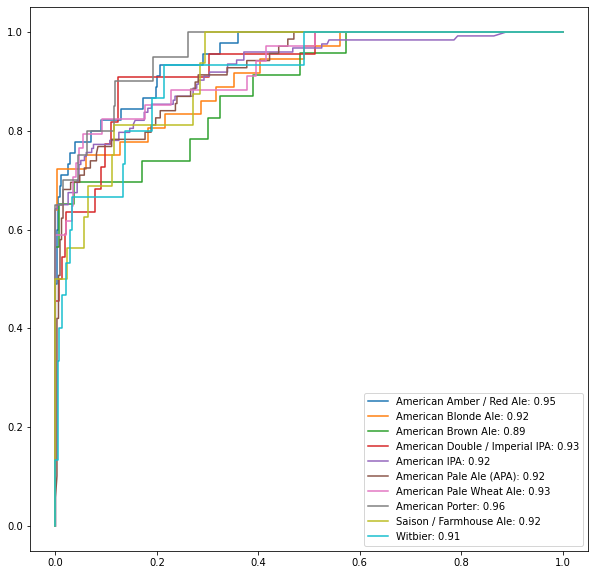

In [13]:
scores = rf.predict_proba(X_test)
classes = numpy.unique(Y_train)

fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(1, 1, 1)
for i in range(10):
    fpr, tpr, _ = roc_curve(Y_test, scores[:,i], pos_label=classes[i])
    auc_score = auc(fpr, tpr)
    ax.plot(fpr, tpr, label='%s: %0.2f' % (classes[i], auc_score))
ax.legend()

However, this is not entirely representitive of how we'd actually use such an output, which would usually be something like this:

In [14]:
print(numpy.argmax(scores, axis=1))

[6 5 4 6 5 0 2 5 4 4 4 4 6 4 4 1 4 4 4 4 0 5 7 0 2 5 0 4 4 4 5 4 4 4 5 4 0
 4 1 4 4 4 4 4 2 4 0 9 5 4 4 4 4 4 4 4 4 6 4 0 1 4 0 4 5 6 4 5 4 4 2 2 4 5
 4 9 8 4 4 6 4 1 9 0 0 4 4 4 4 4 5 2 1 1 5 4 6 4 4 4 4 9 4 5 1 4 1 3 5 0 7
 5 1 2 9 2 6 0 5 0 3 4 4 5 4 4 5 4 4 4 4 4 1 1 4 4 0 1 0 5 7 1 4 6 1 0 4 4
 6 0 5 5 4 0 6 4 4 4 0 6 5 5 6 4 0 1 4 4 4 4 4 8 5 0 4 5 7 6 4 4 4 4 4 4 4
 4 4 0 1 1 4 6 1 0 4 4 4 4 0 4 4 3 5 4 3 4 4 4 4 4 4 5 0 4 4 4 4 4 0 1 4 1
 4 3 2 0 5 4 4 4 5 4 4 4 4 4 4 7 2 4 5 4 2 4 9 4 4 6 6 4 4 6 4 0 5 4 7 4 4
 4 5 4 0 4 0 0 3 5 5 1 4 5 4 0 4 4 4 4 4 0 1 4 5 1 5 1 4 5 3 4 1 4 4 7 3 0
 4 1 5 5 4 4 4 4 4 1 3 4 5 4 7 4 4 5 1 1 3 5 0 7 4 5 4 0 7 4 1 7 0 4 4 4 4
 4 4 4 1 6 5 1 4 4 4 4 7 4 4 5 4 5 4 4 4 9 5 4 0 4 4 3 5 4 4 4 7 0 4 3 4 4
 2 2 0 5 5 4 6 1 1 4 4 8 4 5 5 4 0 4 9 5 4 5 8 1 4 4 0 6 0 6 3 9 4]


In the above, we're simply finding the class with the highest likelihood in each sample, and returning that as the classification output, which is a more typical way to use a multi-class classifier, and this is not something that is captured by the ROC curve.

That said, the above ROC curves are still useful for understanding system performance and providing further insights, and you can do the same thing with a DET curve.

## Final Thoughts

So what have we learned today?

Accuracy, while simple, is a limited measure of classifier performance, it can be distorted by class distributions and doesn't capture the types of errors that a model is making. 

Precision, Recall the F1 Score (which combines the two) provide a more nuanced view of classifier performance. These metrics are still not perfect, but they paint a more complete picture of a classifier's performance.

Does this means that we should stop using accuracy? Not necessarily. It is a very simple and intuitive metric which makes it good for quick tests when exploring things, but we should treat it with a degree of caution, and be prepared to break out the big guns (i.e. precision, recall and F1) when things get serious.